In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import time
tf.logging.set_verbosity(tf.logging.INFO)

In [2]:
import os
import os.path as osp
data_dir='/mnt/data/tshirt_images/'
files = os.listdir(data_dir)
file_list = [osp.join(data_dir, f) for f in files][:1000]

In [3]:
IMAGE_SIZE = 224
def preprocess_image(image_file):
    #image_file = tf.train.slice_input_producer(image_files)
    image_encoded = tf.read_file(image_file)
    image = tf.image.decode_image(image_encoded, channels=3, dtype=tf.float32)
    # debug
    image = tf.Print(image, [image], message="preprocessing image")
    image_padded = tf.image.resize_image_with_pad(image, target_height=IMAGE_SIZE, target_width=IMAGE_SIZE)
    image_padded.set_shape(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    return image_padded

embs=None
batch_size = 2

with tf.Graph().as_default():
    with tf.Session() as sess:
        MOBILE_V2_MODULE='https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2'
        NASNET_MOBILE='https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/1'
        module = hub.Module(NASNET_MOBILE)
        print('module loaded')

        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer())
        print('init done')
        
        image_files = tf.convert_to_tensor(file_list, dtype=tf.string)
        images=tf.map_fn(preprocess_image, image_files, dtype=tf.float32)
        # input_queue = tf.train.slice_input_producer([image_files])
        
        #image_encoded = tf.read_file(input_queue[0])
        
        #preprocessed_image = preprocess_image(image)
        #images = tf.train.batch([preprocessed_image], batch_size=batch_size, allow_smaller_final_batch=True)
        #images = tf.Print(images, [images], message="all images processed")
        embs = module(images)
        #embs = module([preprocessed_image])
        embs = sess.run(embs)
        

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
module loaded
init done
Instructions for updating:
Use the `axis` argument instead
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [4]:
embs.shape

(1000, 1056)

In [71]:
# Make a queue of file names including all the JPEG images files in the relative
# image directory.
filename_queue = tf.train.string_input_producer(file_list, num_epochs=1)

# Read an entire image file which is required since they're JPEGs, if the images
# are too large they could be split in advance to smaller files or use the Fixed
# reader to split up the file.
image_reader = tf.WholeFileReader()

# Read a whole file from the queue, the first returned value in the tuple is the
# filename which we are ignoring.
# _, image_file = image_reader.read_up_to(filename_queue, 123)
_, image_file = image_reader.read(filename_queue)

# Decode the image as a JPEG file, this will turn it into a Tensor which we can
# then use in training.
image = tf.image.decode_jpeg(image_file)

# Start a new session to show example output.
with tf.Session() as sess:
    # Required to get the filename matching to run.
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
#     sess.run(tf.tables_initializer())
#     tf.initialize_all_variables().run()

    # Coordinate the loading of image files.
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    # Get an image tensor and print its value.
    image_tensor = tf.train.batch([image], batch_size=20)
#     print(image_tensor[0])

    # Finish off the filename queue coordinator.
    coord.request_stop()
    coord.join(threads)

ValueError: All shapes must be fully defined: [TensorShape([Dimension(None), Dimension(None), Dimension(None)])]

In [69]:
image_tensor[0].shape

(300, 141, 3)

In [34]:
assert len(files)==embs.shape[0]

NameError: name 'embs' is not defined

In [3]:
import os
import os.path as osp
data_dir='/mnt/data/tshirt_images'
os.mkdir(data_dir)

FileExistsError: [Errno 17] File exists: '/mnt/data/tshirt_images'

In [6]:
data={'fsns': [f.split('.')[0] for f in files],'embs': embs}
import pickle as pk
import os.path as osp
with open(osp.join(data_dir,'feature_vecs.pk'),'wb') as f:
    pk.dump(data, f)

In [10]:
with open(osp.join(data_dir,'feature_vecs.pk'),'rb') as f:
    data=pk.load(f)

In [13]:
fsns=data['fsns']
embs=data['embs']

In [82]:
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# kdt = KDTree(embs, leaf_size=30, metric='euclidean')
imgs=[mpimg.imread(osp.join(data_dir, f+'.jpg')) for f in fsns]
imgs=np.array(imgs)

import matplotlib
matplotlib.rcParams['figure.figsize'] = [17, 8]

In [78]:
def plot_images(imgs):
    f, axarr = plt.subplots(1,len(imgs))
    for idx in range(len(imgs)):
        axarr[idx].imshow(imgs[idx])

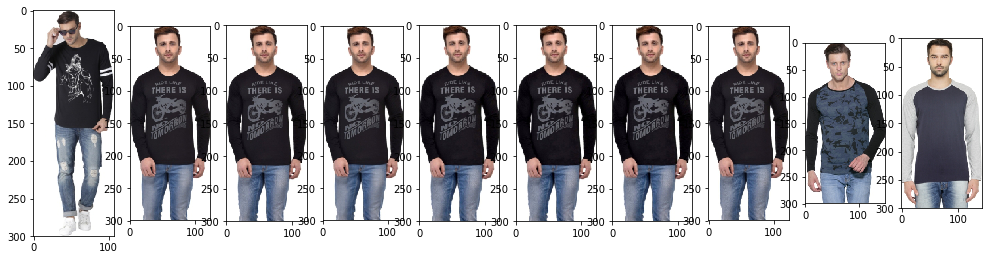

In [456]:
from random import randint
Q_IDX=randint(0, len(files))
NUM_NN=10
nns=kdt.query(embs[Q_IDX:Q_IDX+1], k=NUM_NN, return_distance=False)

In [458]:
from sklearn.cluster import KMeans

In [485]:
N_CLUSTERS=100
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(embs)

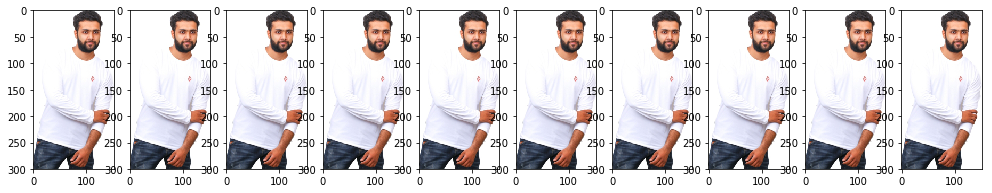

In [502]:
LOOK_LABEL=randint(0, N_CLUSTERS)
# imgs[kmeans.labels_==LOOK_LABEL]
plot_images(np.random.choice(imgs[kmeans.labels_==LOOK_LABEL], 10))

# kmeans clustering to remove duplicates

In [507]:
def get_inertias(labels, data):
    unq_labels=list(frozenset(labels))
    unq_labels.sort()
    for label in unq_labels:
        _data=data[labels==label]
        _kmeans=KMeans(n_clusters=1, random_state=0).fit(_data)
        yield (label, _kmeans.inertia_)
intertias=list(get_inertias(kmeans.labels_, embs))

In [512]:
intertias=[(x[0],int(x[1])) for x in intertias]
intertias=sorted(intertias, key=lambda x: x[1])

inertia for label: 67 is: 0


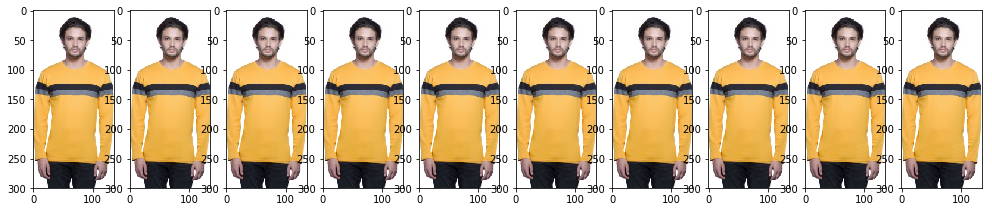

In [549]:
ctr=0
ctr+=1
LOOK_LABEL=intertias[ctr][0]
print("inertia for label: {} is: {}".format(intertias[ctr][0], intertias[ctr][1]))
plot_images(np.random.choice(imgs[kmeans.labels_==LOOK_LABEL], 10))

# linkage clustering for bi-choice navigation

In [14]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [15]:
Z=linkage(embs, 'ward')
from scipy.cluster.hierarchy import to_tree
root=to_tree(Z)

## Use case 1: find duplicates

In [75]:
def get_duplicates(node):
    if node.is_leaf():
        return
    if node.count>1 and node.dist<5:
        yield node
        return
    yield from get_duplicates(node.get_left())
    yield from get_duplicates(node.get_right())
    
dups=list(get_duplicates(root))
dups=sorted(dups, key=lambda x: x.get_count(), reverse=True)

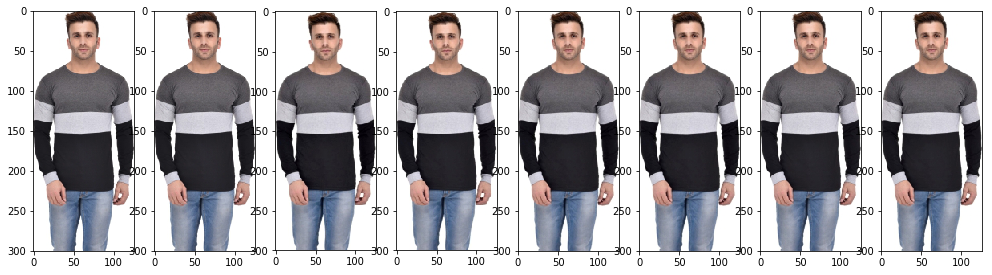

In [83]:
ctr=0
ctr+=1
plot_images(imgs[dups[ctr].pre_order(lambda x: x.id)])

## Usecase 2: bi-choice navigation

In [16]:
from random import choice
def navigate(nd):
    if nd.is_leaf():
        return (nd.id, nd.id, nd)
    left_sample = choice(nd.left.pre_order(lambda x: x.id))
    right_sample = choice(nd.right.pre_order(lambda x: x.id))
    print("left: {} right: {}".format(nd.left.count, nd.right.count))
    return (left_sample, right_sample)
#     if nd.left.count < nd.right.count:
#         print('going left')
#         next_nav=nd.left
#     else:
#         print('going right')
#         next_nav=nd.right
#     return (left_sample, right_sample, next_nav)



In [56]:
from bokeh.io import output_notebook, show
from bokeh.layouts import widgetbox
from bokeh.models.widgets import Button
from bokeh.plotting import reset_output, figure
from bokeh.models import ColumnDataSource

reset_output()
output_notebook()

Loading BokehJS ...

In [87]:
def navigate_doc(doc):
    p = figure(x_range=(0,2), y_range=(0,1))
    global next_nav
    next_nav=root
    display_image=osp.join('data/tshirt_images', fsns[0]+'.jpg')
    print(display_image)
    display_images=[display_image]
    left_src = ColumnDataSource(dict(url = [display_image]))
    right_src = ColumnDataSource(dict(url = [display_image]))
    def nav(direction):
        global next_nav
        next_nav = next_nav.left if direction=='l' else next_nav.right
        left_sample, right_sample = navigate(next_nav)
        #print(fsns[left_sample])
        for sample, src in [(left_sample, left_src), (right_sample, right_src)]:
            display_image=osp.join('data/tshirt_images', fsns[sample]+'.jpg')
            src.data = ColumnDataSource(dict(url=[display_image, display_image])).data
        
    def nav_left():
        nav('l')
    def nav_right():
        nav('r')
    for x in [('left',nav_left), ('right',nav_right)]:
        btn = Button(label=x[0], button_type="success")
        btn.on_click(x[1])
        doc.add_root(btn)
    p.image_url(url='url', x=0.0, y = 1.0, h=1.0, w=1.0, source=left_src)
    p.image_url(url='url', x=1.0, y = 1.0, h=1.0, w=1.0, source=right_src)
    doc.add_root(p)
    
show(navigate_doc)

data/tshirt_images/SRTEX9DQHDCHB3YM.jpg
left: 316 right: 357
left: 159 right: 198
left: 36 right: 123
left: 24 right: 99
left: 10 right: 14



# Scrape tshirt images

In [12]:
import requests as req
uri="https://www.flipkart.com/search?q=t+shirts&sid=2oq%2Fs9b%2Fj9y&page=2"
data=req.get(uri)

In [13]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(data.content,'html.parser')
# data.content

In [14]:
# soup.findAll('img')[1]['src']

In [15]:
import subprocess as sp
import json

In [16]:
def gen_dict_extract(key, var):
    if hasattr(var,'items'):
        for k, v in var.items():
            if k == key:
                yield v
            if isinstance(v, dict):
                for result in gen_dict_extract(key, v):
                    yield result
            elif isinstance(v, list):
                for d in v:
                    for result in gen_dict_extract(key, d):
                        yield result

In [17]:
def get_products(page_no):
    cmd='''curl 'https://www.flipkart.com/api/4/page/fetch' -H 'Pragma: no-cache' -H 'X-user-agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/68.0.3440.106 Safari/537.36 FKUA/website/41/website/Desktop' -H 'Origin: https://www.flipkart.com' -H 'Accept-Encoding: gzip, deflate, br' -H 'Accept-Language: en-US,en;q=0.9' -H 'User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/68.0.3440.106 Safari/537.36' -H 'Content-Type: application/json' -H 'Accept: */*' -H 'Cache-Control: no-cache' -H 'Referer: https://www.flipkart.com/men/tshirts/pr?p%5B%5D=sort%3Dpopularity&p%5B%5D=facets.sleeve%5B%5D%3DFull+Sleeve&p%5B%5D=facets.discount_range_v1%5B%5D%3D50%25+or+More&sid=2oq%2Cs9b%2Cj9y&otracker=sp_browse_reco_T-Shirts_2oq%2Cs9b%2Cj9y&page=2' -H 'Cookie: AMCVS_17EB401053DAF4840A490D4C%40AdobeOrg=1; s_ch_list=%5B%5B%27Direct%2528No%2520referrer%2529%27%2C%271511435645694%27%5D%5D; _ga=GA1.2.593281373.1511181985; __utmc=19769839; __utmz=19769839.1511181985.1.1.utmcsr=(direct)|utmccn=(direct)|utmcmd=(none); T=TI151086950726123468601139041124242245322889019638061097026684813886; s_cc=true; __utma=19769839.593281373.1511181985.1523437239.1528372362.8; AMCVS_55CFEDA0570C3FA17F000101%40AdobeOrg=1; _mkto_trk=id:021-QVV-957&token:_mch-flipkart.com-1532698768896-88130; JSESSIONID=1rgzbenppqcj1q6q447x6gtx5; _gid=GA1.2.1808290174.1534417542; AMCV_17EB401053DAF4840A490D4C%40AdobeOrg=-227196251%7CMCIDTS%7C17761%7CMCMID%7C16663144231486822789048632830748816499%7CMCAAMLH-1534770704%7C3%7CMCAAMB-1535097331%7CRKhpRz8krg2tLO6pguXWp5olkAcUniQYPHaMWWgdJ3xzPWQmdj0y%7CMCOPTOUT-1534499731s%7CNONE%7CMCAID%7CNONE; AMCV_55CFEDA0570C3FA17F000101%40AdobeOrg=-227196251%7CMCIDTS%7C17760%7CMCMID%7C25367029007859109895353533875180721926%7CMCOPTOUT-1534513072s%7CNONE%7CMCAID%7C2D07F7A0052A1B2E-6000010300000B29; s_ppvl=seller%253A%2520manage%2520profile%2C100%2C100%2C821%2C1440%2C821%2C1920%2C1080%2C1%2CP; s_ppv=seller%253A%2520manage%2520profile%2C100%2C100%2C821%2C1440%2C776%2C1440%2C900%2C2%2CP; s_nr=1534511265951-Repeat; VID=2.VIEA97F7C1CC1844E38455E75CF958D734.1534536279.VS153453627946660912568; NSID=2.SI307CB6699690426ABFA9ABBBCAF1F658.1534536279.VIEA97F7C1CC1844E38455E75CF958D734; aid=CIlaWdpv6%2FyiIyAuJttR6CFuw%2BcngArE5VquqKvzdWT2SgMVJZc%2BqvO1i79XQ9Et; qH=ce85dd0df15cfd3a; SN=2.VIEA97F7C1CC1844E38455E75CF958D734.SI307CB6699690426ABFA9ABBBCAF1F658.VS153453627946660912568.1534573155; gpv_pn=Store%20%3AClothing%7CMen%27s%20Clothing%7CT-Shirts; gpv_pn_t=Store%20Browse; S=d1t12dARJUTM/Bx5TPz8/Pz9qP/Ip1tsArFqGclQEXDpJ9NXIA83jEHGW83Qn4LSs3gPfa4kYQWAYz2nAtU52YsqrfQ==; s_sq=flipkartsellerprod%3D%2526pid%253Dhttps%25253A%25252F%25252Fsuv-ui.vip.nm.flipkart.com%25252FsellerDashboard%25252Findex.html%25253FsellerId%25253Dc869ea479600487e%252523dashboard%25252FselectionInsights%2526oid%253Dfunction%252528%252529%25257B%25257D%2526oidt%253D2%2526ot%253DDIV' -H 'Connection: keep-alive' --data-binary '{"pageUri":"/men/tshirts/pr?p%5B%5D=sort%3Dpopularity&p%5B%5D=facets.sleeve%5B%5D%3DFull+Sleeve&p%5B%5D=facets.discount_range_v1%5B%5D%3D50%25+or+More&sid=2oq%2Cs9b%2Cj9y&otracker=sp_browse_reco_T-Shirts_2oq%2Cs9b%2Cj9y&page=2","requestContext":{"type":"BROWSE_PAGE"},"pageContext":{"paginatedFetch":true,"pageNumber":<PAGE_NO>,"paginationContextMap":{"federator":{"ADS":7,"layout":"grid","MERCH_CARD":0,"PAGINATION_BAR":0,"pageNumber":<PAGE_NO>,"INLINE_FILTER":0,"FILTER_SORT_OPTIONS":0,"PRODUCT":33,"AUGMENTATION_CARD":0,"INLINE_GUIDE":0,"SERVICEABILITY_FILTER":0,"store.path":"2oq/s9b/j9y"}}}}' --compressed'''
    #cmd='''curl 'https://www.flipkart.com/api/4/page/fetch' -H 'Pragma: no-cache' -H 'X-user-agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/68.0.3440.106 Safari/537.36 FKUA/website/41/website/Desktop' -H 'Origin: https://www.flipkart.com' -H 'Accept-Encoding: gzip, deflate, br' -H 'Accept-Language: en-US,en;q=0.9' -H 'User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/68.0.3440.106 Safari/537.36' -H 'Content-Type: application/json' -H 'Accept: */*' -H 'Cache-Control: no-cache' -H 'Referer: https://www.flipkart.com/search?q=t+shirts&sid=2oq%2Fs9b%2Fj9y&page=3' -H 'Cookie: AMCVS_17EB401053DAF4840A490D4C%40AdobeOrg=1; s_ch_list=%5B%5B%27Direct%2528No%2520referrer%2529%27%2C%271511435645694%27%5D%5D; _ga=GA1.2.593281373.1511181985; __utmc=19769839; __utmz=19769839.1511181985.1.1.utmcsr=(direct)|utmccn=(direct)|utmcmd=(none); T=TI151086950726123468601139041124242245322889019638061097026684813886; s_cc=true; __utma=19769839.593281373.1511181985.1523437239.1528372362.8; AMCVS_55CFEDA0570C3FA17F000101%40AdobeOrg=1; _mkto_trk=id:021-QVV-957&token:_mch-flipkart.com-1532698768896-88130; JSESSIONID=1rgzbenppqcj1q6q447x6gtx5; _gid=GA1.2.1808290174.1534417542; AMCV_17EB401053DAF4840A490D4C%40AdobeOrg=-227196251%7CMCIDTS%7C17761%7CMCMID%7C16663144231486822789048632830748816499%7CMCAAMLH-1534770704%7C3%7CMCAAMB-1535097331%7CRKhpRz8krg2tLO6pguXWp5olkAcUniQYPHaMWWgdJ3xzPWQmdj0y%7CMCOPTOUT-1534499731s%7CNONE%7CMCAID%7CNONE; AMCV_55CFEDA0570C3FA17F000101%40AdobeOrg=-227196251%7CMCIDTS%7C17760%7CMCMID%7C25367029007859109895353533875180721926%7CMCOPTOUT-1534513072s%7CNONE%7CMCAID%7C2D07F7A0052A1B2E-6000010300000B29; s_ppvl=seller%253A%2520manage%2520profile%2C100%2C100%2C821%2C1440%2C821%2C1920%2C1080%2C1%2CP; s_ppv=seller%253A%2520manage%2520profile%2C100%2C100%2C821%2C1440%2C776%2C1440%2C900%2C2%2CP; s_nr=1534511265951-Repeat; qH=04ad3bdbbe706182; VID=2.VIEA97F7C1CC1844E38455E75CF958D734.1534536279.VS153453627946660912568; NSID=2.SI307CB6699690426ABFA9ABBBCAF1F658.1534536279.VIEA97F7C1CC1844E38455E75CF958D734; aid=CIlaWdpv6%2FyiIyAuJttR6CFuw%2BcngArE5VquqKvzdWT2SgMVJZc%2BqvO1i79XQ9Et; gpv_pn=Search%20%3AClothing%7CMen%27s%20Clothing%7CT-Shirts; gpv_pn_t=Search%20Page; SN=2.VIEA97F7C1CC1844E38455E75CF958D734.SI307CB6699690426ABFA9ABBBCAF1F658.VS153453627946660912568.1534537284; S=d1t12P35LP1lLXD8/LD8/MT8/P/DeUxhP07OYZjTnzRzUpoTVakmg7nBhqHvVxvEAeJvFou0YFXoqo8jBDJgVv0NIRA==; s_sq=flipkartsellerprod%3D%2526pid%253Dhttps%25253A%25252F%25252Fsuv-ui.vip.nm.flipkart.com%25252FsellerDashboard%25252Findex.html%25253FsellerId%25253Dc869ea479600487e%252523dashboard%25252FselectionInsights%2526oid%253Dfunction%252528%252529%25257B%25257D%2526oidt%253D2%2526ot%253DDIV' -H 'Connection: keep-alive' --data-binary '{"pageUri":"/search?q=t+shirts&sid=2oq%2Fs9b%2Fj9y&page=3","requestContext":{"type":"BROWSE_PAGE"},"pageContext":{"paginatedFetch":true,"pageNumber": <PAGE_NO>,"paginationContextMap":{"federator":{"ADS":8,"layout":"grid","MERCH_CARD":0,"PAGINATION_BAR":0,"pageNumber":2,"INLINE_FILTER":0,"FILTER_SORT_OPTIONS":0,"PRODUCT":72,"AUGMENTATION_CARD":0,"INLINE_GUIDE":0,"SERVICEABILITY_FILTER":0,"store.path":"2oq/s9b/j9y"}}}}' --compressed'''
    cmd=cmd.replace('<PAGE_NO>', str(page_no))
    op=sp.check_output(cmd, shell=True)
    resp=json.loads(op.decode('utf-8'))
    products=[]
    p_groups=list(gen_dict_extract('products',resp))
    [products.extend(x) for x in p_groups]
    for product_info in products:
        fsn=gen_dict_extract('productId', product_info).__next__()
        image_uri=gen_dict_extract('images', product_info).__next__()[0]
        yield {'fsn':fsn, 'image': image_uri}

In [18]:
NO_OF_FSNS = min(10000, 2000)# 2k is the limit for crawl
fsns=[]
[fsns.extend(get_products(page_no)) for page_no in range(1,(NO_OF_FSNS//40)+1)]
len(fsns)

2000

In [19]:
len(set([x['fsn'] for x in fsns]))

1751

In [20]:
# make batches of 100 and fetch them
BATCH_SIZE=100
fsn_batches = [fsns[i*BATCH_SIZE:(i+1)*BATCH_SIZE] for i in range(len(fsns)//BATCH_SIZE)]

In [23]:
import urllib
import subprocess as sp
IMAGE_DIM=300

def batch_download(fsns, idx):
    print("{}/{}".format(idx+1, len(fsn_batches)))
    for fsn_info in fsns:
        img_uri=fsn_info['image']['url'].replace('{@width}', str(IMAGE_DIM)).replace('{@height}', str(IMAGE_DIM)).replace('{@quality}', str(100))
        fsn=fsn_info['fsn']
        dump_file=osp.join(data_dir,'{}.jpg'.format(fsn))
        cmd="curl -o {0} '{1}' &".format(dump_file, img_uri)
        sp.call(cmd, shell=True)
        # urllib.request.urlretrieve(img_uri, osp.join(data_dir,'{}.jpg'.format(fsn)))
status=[batch_download(fsn_batch, idx) for idx,fsn_batch in enumerate(fsn_batches)]

1/20
2/20
3/20
4/20
5/20
6/20
7/20
8/20
9/20
10/20
11/20
12/20
13/20
14/20
15/20
16/20
17/20
18/20
19/20
20/20


In [391]:
set([x['fsn'] for x in fsns])

{'TSHEAZDHTKWGVVFP',
 'TSHEAZDHZSC68T8Z',
 'TSHEAZDKZH2C6DWW',
 'TSHEN7WHFH2FSBUB',
 'TSHEN7WNMBTAXX58',
 'TSHENQ5CY2FFTUV3',
 'TSHEPZZC7HZJFQW9',
 'TSHEQ54WGRANYTHY',
 'TSHEQ54WQVCFWPBN',
 'TSHEQ54X7ZNYY2ZZ',
 'TSHERB6G8XFBXTFR',
 'TSHERBWVBWPDMUC6',
 'TSHERHW94UKXZZTG',
 'TSHES7HGWHHVZNHA',
 'TSHESKUJNHKRSZQA',
 'TSHESKUTAPEWGVHZ',
 'TSHESRKPHZYNPUG7',
 'TSHESRKZDEFUTJNW',
 'TSHESRKZRVGHFZRF',
 'TSHESWPWKZHVSYFH',
 'TSHETC9XFY3JY95X',
 'TSHETNS3YBUYS5FA',
 'TSHETXGZPWYV9D3G',
 'TSHEUYQVWEYJQ2CK',
 'TSHEVPYJGWXZSP5C',
 'TSHEW257Z648GF32',
 'TSHEWFREXUBGYXHR',
 'TSHEWFSKTCRHZ5BD',
 'TSHEWM93HE6BYMUB',
 'TSHEX8HNZGXVQSZ5',
 'TSHEX9GUKZMSQ9VW',
 'TSHEXMT5WBSVPTPD',
 'TSHEXQ7KJAGZTT9V',
 'TSHEXQ7KNZJQPHEM',
 'TSHEXR88AKVEYCCH',
 'TSHEXR88EYCYVG8N',
 'TSHEXR88N6VFGH7K',
 'TSHEXR88ZFHGFFWB',
 'TSHEXTHSHHYCT2YV',
 'TSHEYKBY6TVHJMGJ',
 'TSHEYYDEKMRNFJXQ',
 'TSHEZ8CYTSHZFSVX',
 'TSHEZAEQCDNGJZZM',
 'TSHEZJG23HMPH79X',
 'TSHEZJHHXFGN6D9M',
 'TSHEZZG2VZFDXV3N',
 'TSHF2KVZZKU9CDUG',
 'TSHF2R5RV9D

# ------------- scraping done ----------------

# Visualize TSNe

In [354]:
PRJOECTOR_OP_PATH = '/Users/akshit.jain/repos/embedding-projector-standalone/oss_data'
np.savetxt(PRJOECTOR_OP_PATH+'/tshirt_embs.tsv', embs, delimiter='\t')

In [355]:
embs.shape

(430, 1056)

In [40]:
import urllib.request
from bs4 import BeautifulSoup as BS
from urllib.parse import urlparse, parse_qs
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [95]:
! pip install Pillow

    100% |████████████████████████████████| 3.6MB 1.1MB/s ta 0:00:011


In [360]:
imgs[0].shape

(300, 151, 3)

In [362]:
#!/usr/bin/python

from PIL import Image, ImageOps
import math


grid = int(math.ceil(len(imgs)**0.5))
image_height = image_width = 50

def pad_to_square(im):
    dim = max(im.size)
    delta_w = dim - im.size[0]
    delta_h = dim - im.size[1]
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    return ImageOps.expand(im, padding)
    
big_image = Image.new(
    mode='RGB',
    size=(image_width * grid, image_height * grid),
    color=(0,0,0))  # fully transparent

for i in range(len(imgs)):
    row = i // grid
    col = i % grid
    img = Image.fromarray(imgs[i])
    # img = Image.open(files[i])
    img = pad_to_square(img)
    img = img.resize((image_height, image_width), Image.ANTIALIAS)
    row_loc = row * image_height
    col_loc = col * image_width
    big_image.paste(img, (col_loc, row_loc)) # NOTE: the order is reverse due to PIL saving
    print(row_loc, col_loc)

big_image.save('/Users/akshit.jain/repos/embedding-projector-standalone/oss_data/tshirt_sprite.png')

0 0
0 50
0 100
0 150
0 200
0 250
0 300
0 350
0 400
0 450
0 500
0 550
0 600
0 650
0 700
0 750
0 800
0 850
0 900
0 950
0 1000
50 0
50 50
50 100
50 150
50 200
50 250
50 300
50 350
50 400
50 450
50 500
50 550
50 600
50 650
50 700
50 750
50 800
50 850
50 900
50 950
50 1000
100 0
100 50
100 100
100 150
100 200
100 250
100 300
100 350
100 400
100 450
100 500
100 550
100 600
100 650
100 700
100 750
100 800
100 850
100 900
100 950
100 1000
150 0
150 50
150 100
150 150
150 200
150 250
150 300
150 350
150 400
150 450
150 500
150 550
150 600
150 650
150 700
150 750
150 800
150 850
150 900
150 950
150 1000
200 0
200 50
200 100
200 150
200 200
200 250
200 300
200 350
200 400
200 450
200 500
200 550
200 600
200 650
200 700
200 750
200 800
200 850
200 900
200 950
200 1000
250 0
250 50
250 100
250 150
250 200
250 250
250 300
250 350
250 400
250 450
250 500
250 550
250 600
250 650
250 700
250 750
250 800
250 850
250 900
250 950
250 1000
300 0
300 50
300 100
300 150
300 200
300 250
300 300
300 350
300 40

In [365]:
# l /Users/akshit.jain/repos/embedding-projector-standalone
np.savetxt('/Users/akshit.jain/repos/embedding-projector-standalone/oss_data/tshirt_labels.tsv', np.array(files), delimiter='\t', fmt='%s')# ,fmt='%d'


In [157]:
np.array(list(range(40)))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])